<a href="https://colab.research.google.com/github/JUNYA-727/bitcoin_system_trading/blob/main/bitcoin_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**ビットコインを自動売買のモデルで作成する。**

**APIを使って自動売買を行う前に、シミュレーションを行って勝率、利益を考えてみる。**
*   特徴量はTa-LIbをテクニカル指標を導入する。
*   TensorflowのLSTM、パラメーター最適化Optunaを加えたLightGBMのこれら2つを使って比較を行い、最も高い勝率、利益率のモデルを自動売買のアルゴリズムとして導入を検討する。




In [ ]:
#特徴量として使用するテクニカル指標の計算のライブラリ
!wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
!tar -xzvf ta-lib-0.4.0-src.tar.gz
%cd ta-lib
!./configure --prefix=/usr
!make
!make install
!pip install Ta-Lib

In [62]:
import pandas as pd
import talib
import matplotlib.pyplot as plt
import numpy as np

### データは時系列に並べており、左のコラムから[時間、始値、高値、安値、終値、出来高]
### 短期売買を目的としているため、今回は15分ごとのデータから予測を行う

**データの内容はBTC/USDで15分足のcsvファイル**

**左のコラムから､時間､始値､高値､安値､終値､出来高に並んでいる**


# データの基礎的な処理から､特徴量となるテクニカル指標を加えるまで

In [63]:
df=pd.read_csv('/content/drive/MyDrive/btc 9月12日-11月26日.csv')
df.head(10)

,2021-09-12 14:45:00,45853.99,45857.72,45842.03,45857.72.1,0.8006
0,2021-09-12 15:00:00,45896.18,45896.18,45819.53,45819.53,0.500400
1,2021-09-12 15:15:00,45813.99,45813.99,45813.99,45813.99,0.010000
2,2021-09-12 15:45:00,45834.92,45834.92,45747.05,45747.05,1.760000
3,2021-09-12 16:00:00,45807.04,45881.14,45807.04,45881.14,0.018020
4,2021-09-12 16:15:00,45881.14,45881.14,45881.14,45881.14,1.278035
5,2021-09-12 16:30:00,45912.12,45915.42,45912.12,45915.42,0.800800
6,2021-09-12 16:45:00,45915.42,45932.63,45915.42,45932.62,1.213700
7,2021-09-12 18:30:00,45744.99,45744.99,45744.99,45744.99,0.308548
8,2021-09-12 19:45:00,45841.83,45845.67,45841.83,45845.67,0.152000
9,2021-09-12 20:15:00,45935.70,45935.70,45935.70,45935.70,0.400400


In [64]:
#今回は終値だけに注目して使用する。
df1=df.iloc[0:,4:5]
df1.columns=['price']

In [65]:
df1.head(3)

,price
0,45819.53
1,45813.99
2,45747.05


In [66]:
#特徴量の追加
#特徴量はボリンジャーバンド、SMA、RSI、MACDを使用する。
df1['sma20']=talib.SMA(df1['price'],timeperiod=20)
up,middle,low=talib.BBANDS(df1['price'],timeperiod=20,nbdevdn=3,nbdevup=3,matype=0)
df1['bb_up']=up
df1['bb_low']=low

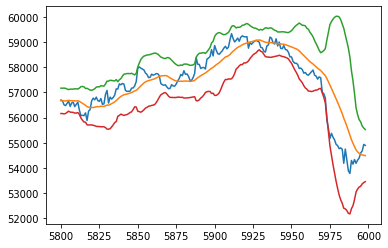

In [67]:
plt.plot(df1[5800:])

In [68]:
macd,macdsignal,macdhist=talib.MACD(df1['price'],fastperiod=12,slowperiod=26,signalperiod=9)
df1['macd']=macd
df1['macdsignal']=macdsignal
df1['macdhist']=macdhist
df1['rsi9']=talib.RSI(df1['price'],timeperiod=9)
df1['rsi14']=talib.RSI(df1['price'],timeperiod=14)

In [69]:
df2=df1[33:].reset_index(drop=True)

In [70]:
df2.head(3)

,price,sma20,bb_up,bb_low,macd,macdsignal,macdhist,rsi9,rsi14
0,44965.86,45390.5885,46470.316081,44310.860919,-183.907162,-124.689976,-59.217186,34.422632,37.051169
1,44654.39,45350.6455,46531.145587,44170.145413,-212.402074,-142.232396,-70.169679,25.696322,31.249201
2,44529.61,45298.9325,46584.388807,44013.476193,-242.260572,-162.238031,-80.022541,23.061477,29.271623


In [71]:
df3=df2[['price']]

In [72]:
df4=df2[1:].reset_index(drop=True)

In [73]:
df4.head(3)

,price,sma20,bb_up,bb_low,macd,macdsignal,macdhist,rsi9,rsi14
0,44654.39,45350.6455,46531.145587,44170.145413,-212.402074,-142.232396,-70.169679,25.696322,31.249201
1,44529.61,45298.9325,46584.388807,44013.476193,-242.260572,-162.238031,-80.022541,23.061477,29.271623
2,44637.84,45262.3665,46616.919708,43907.813292,-254.259446,-180.642314,-73.617132,30.059392,33.219226


# データのラベル付けから､Tensorflowで学習するところまで
**主にラベル付けは0:stay(エントリーしていたら保有､していない状態がエントリーしない)､1:sell(売り注文)､2:buy(買い注文)の3パターン**

**比較として0:sell,1:buyの2パターンと利益の大きさを比べる**




In [74]:
#選択肢としてsell,stay,buyの3つを正解ラベルとして与える。
price=np.array(df3['price'])
PRICE=[]
sell=[]
stay=[]
buy=[]
for i in range(len(price)-1):
  new=price[i+1]-price[i]
  PRICE.append(new)
  if -10.0<=new<=10.0:
    stay.append(1)
    sell.append(0)
    buy.append(0)
    continue
  elif new<-10.0:
    stay.append(0)
    sell.append(1)
    buy.append(0)
    continue
  elif 10.0<new:
    stay.append(0)
    sell.append(0)
    buy.append(1)
    continue

In [75]:
df4.insert(0,'stay',stay)
df4.insert(1,'sell',sell)
df4.insert(2,'buy',buy)

In [76]:
df4.head(3)

,stay,sell,buy,price,sma20,bb_up,bb_low,macd,macdsignal,macdhist,rsi9,rsi14
0,0,1,0,44654.39,45350.6455,46531.145587,44170.145413,-212.402074,-142.232396,-70.169679,25.696322,31.249201
1,0,1,0,44529.61,45298.9325,46584.388807,44013.476193,-242.260572,-162.238031,-80.022541,23.061477,29.271623
2,0,0,1,44637.84,45262.3665,46616.919708,43907.813292,-254.259446,-180.642314,-73.617132,30.059392,33.219226


In [77]:
def create_window(window_size,split_size,df):
  train=[]
  test=[]

  price=np.array(df['price'])
  sma20=np.array(df['sma20'])
  bb_up=np.array(df['bb_up'])
  bb_low=np.array(df['bb_low'])
  macd=np.array(df['macd'])
  macdsignal=np.array(df['macdsignal'])
  macdhist=np.array(df['macdhist'])
  rsi9=np.array(df['rsi9'])
  rsi14=np.array(df['rsi14'])

  stay=np.array(df['stay'])
  sell=np.array(df['sell'])
  buy=np.array(df['buy'])
  len_data=len(df['price'])

  for i in range(len_data-window_size):
    t=[]
    t.append(price[i:i+window_size])
    t.append(sma20[i:i+window_size])
    t.append(bb_up[i:i+window_size])
    t.append(bb_low[i:i+window_size])
    t.append(macd[i:i+window_size])
    t.append(macdsignal[i:i+window_size])
    t.append(macdhist[i:i+window_size])
    t.append(rsi9[i:i+window_size])
    t.append(rsi14[i:i+window_size])
    train.append(t)
    ans=[]
    ans.append(stay[i+window_size])
    ans.append(sell[i+window_size])
    ans.append(buy[i+window_size])
    test.append(ans)
  x_train,x_test=train[:int(len_data*split_size)],train[int(len_data*split_size):]
  y_train,y_test=test[:int(len_data*split_size)],test[int(len_data*split_size):]
  x_train=np.array(x_train)
  x_test=np.array(x_test)
  y_train=np.array(y_train)
  y_test=np.array(y_test)
  return x_train,x_test,y_train,y_test

In [78]:
x_train,x_test,y_train,y_test=create_window(5,0.8,df4)

In [79]:
df4

,stay,sell,buy,price,sma20,bb_up,bb_low,macd,macdsignal,macdhist,rsi9,rsi14
0,0,1,0,44654.39,45350.6455,46531.145587,44170.145413,-212.402074,-142.232396,-70.169679,25.696322,31.249201
1,0,1,0,44529.61,45298.9325,46584.388807,44013.476193,-242.260572,-162.238031,-80.022541,23.061477,29.271623
2,0,0,1,44637.84,45262.3665,46616.919708,43907.813292,-254.259446,-180.642314,-73.617132,30.059392,33.219226
3,0,0,1,44648.80,45215.3260,46606.770612,43823.881388,-259.888427,-196.491537,-63.396890,30.776678,33.623247
4,0,0,1,44659.13,45167.9625,46577.329451,43758.595549,-260.512861,-209.295801,-51.217059,31.521343,34.028367
...,...,...,...,...,...,...,...,...,...,...,...,...
5960,0,0,1,54388.82,54577.5875,55920.551371,53234.623629,-664.554571,-772.072844,107.518273,42.765580,36.770630
5961,0,0,1,54591.47,54548.6435,55828.480821,53268.806179,-602.005447,-738.059365,136.053918,48.663916,40.998286
5962,0,0,1,54671.26,54513.3995,55664.673693,53362.125307,-539.774247,-698.402341,158.628094,50.905028,42.624923
5963,0,0,1,54933.69,54498.9480,55583.674461,53414.221539,-463.931749,-651.508223,187.576473,57.732569,47.729206


**TensorFlowのLSTMによる実装**

**stayとsellとbuyの選択肢3つを用意した場合**

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input,LSTM,Dense,BatchNormalization,Dropout
from tensorflow.keras.models import Model
def create_LSTM_model():
  input=Input(shape=(x_train.shape[1],x_train.shape[2]))
  x=LSTM(32)(input)
  x=BatchNormalization()(x)
  x=Dense(16)(x)
  x=Dense(8)(x)
  output=Dense(y_train.shape[1],activation='softmax')(x)
  model=Model(input,output)
  return model
model1=create_LSTM_model()
model1.summary()
Adam=tf.keras.optimizers.Adam(learning_rate=0.001)
model1.compile(optimizer=Adam,loss='categorical_crossentropy',metrics=['accuracy'])
history=model1.fit(x_train,y_train,epochs=500,batch_size=128)

In [81]:
print(len(model1.predict(x_test)))
y_test[0]
check=[]
#testデータで精度の確認
ans=model1.predict(x_test)
for i in range(len(ans)):
  if ans[i][0]>ans[i][1]:
    if ans[i][0]>ans[i][2]:
      check.append(0)
    else:
      check.append(2)
  else:
    if ans[i][1]>ans[i][2]:
      check.append(1)
    else:
      check.append(2)
answer=[]
for i in range(len(y_test)):
  if y_test[i][0]==1:
    answer.append(0)
  elif y_test[i][1]==1:
    answer.append(1)
  else:
    answer.append(2)
game=[]
for i in range(len(answer)):
  if answer[i]==check[i]:
    game.append('win')
  else:
    game.append('lose')
print('予測とテストデータの一致した数:'+str(game.count('win')))
print('予測とテストデータの外した数:'+str(game.count('lose')))
print('stayを予測した数:'+str(check.count(0))+' sellを予測した数:'+str(check.count(1))+' buyを予測した数:'+str(check.count(2)))
print('実際のstayの数:'+str(answer.count(0))+'実際のsellの数:'+str(answer.count(1))+'実際のbuyの数:'+str(answer.count(2)))

1188
予測とテストデータの一致した数:574
予測とテストデータの外した数:614
stayを予測した数:50 sellを予測した数:629 buyを予測した数:509
実際のstayの数:76実際のsellの数:612実際のbuyの数:500


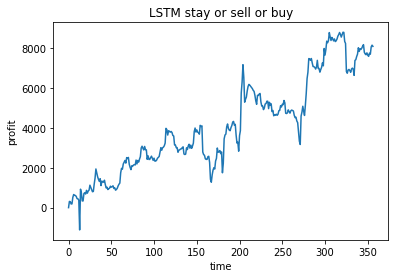

In [82]:
#シミュレーションを行う
money=[0]
profit=0
#haveはエントリーしていない、エントリーしている（sellは1,buyは2)を指す。
have=0
data=0
for i in range(len(ans)):
  #もっていない状態
  if have==0:
    #どういう行動を起こすか
    #stayなのでエントリーは行わない。
    if check[i]==0:
      continue
    #buyなのでbuyでエントリー
    if check[i]==2:
      have=2
      data=i
      continue
    #sellなのでsellでエントリー
    if check[i]==1:
      have=1
      data=i
      continue
  #sellでエントリーしている場合
  if have==1:
    #もし次がstayかsellだと予測した場合は保有
    if (check[i]==0 or check[i]==1):
      continue
    #もし次がbuyだと予測した場合は決済を行う
    if check[i]==2:
      profit+=price[data]-price[i]
      money.append(profit)
      have=0
      continue
  #buyでエントリーしている場合
  if have==2:
    #もし次がstayかbuyだと予測した場合は保有を行う
    if (check[i]==0 or check[i]==2):
      continue
    #もし次がsellだと予測した場合は決済を行う
    if check[i]==1:
      profit+=price[i]-price[data]
      money.append(profit)
      have=0
      continue

plt.plot(money)
plt.title('LSTM stay or sell or buy')
plt.xlabel('time')
plt.ylabel('profit')
plt.savefig('/content1.png')
plt.show()

**Tensorflow LSTMでsellとbuyの選択肢のみ**

In [83]:
df2.head(3)

,price,sma20,bb_up,bb_low,macd,macdsignal,macdhist,rsi9,rsi14
0,44965.86,45390.5885,46470.316081,44310.860919,-183.907162,-124.689976,-59.217186,34.422632,37.051169
1,44654.39,45350.6455,46531.145587,44170.145413,-212.402074,-142.232396,-70.169679,25.696322,31.249201
2,44529.61,45298.9325,46584.388807,44013.476193,-242.260572,-162.238031,-80.022541,23.061477,29.271623


In [84]:
df3.head(3)

,price
0,44965.86
1,44654.39
2,44529.61


In [85]:
#選択肢としてsell,buyの2つを正解ラベルとして与える。
price=np.array(df3['price'])
PRICE=[]
sell=[]
buy=[]
for i in range(len(price)-1):
  new=price[i+1]-price[i]
  PRICE.append(new)
  if 0<new:
    sell.append(0)
    buy.append(1)
  else:
    sell.append(1)
    buy.append(0)
df5=df2[1:].reset_index(drop=True)
df5.insert(0,'sell',sell)
df5.insert(1,'buy',buy)

In [86]:
df5.head(3)

,sell,buy,price,sma20,bb_up,bb_low,macd,macdsignal,macdhist,rsi9,rsi14
0,1,0,44654.39,45350.6455,46531.145587,44170.145413,-212.402074,-142.232396,-70.169679,25.696322,31.249201
1,1,0,44529.61,45298.9325,46584.388807,44013.476193,-242.260572,-162.238031,-80.022541,23.061477,29.271623
2,0,1,44637.84,45262.3665,46616.919708,43907.813292,-254.259446,-180.642314,-73.617132,30.059392,33.219226


In [87]:
def create_window(window_size,split_size,df):
  train=[]
  test=[]

  price=np.array(df['price'])
  sma20=np.array(df['sma20'])
  bb_up=np.array(df['bb_up'])
  bb_low=np.array(df['bb_low'])
  macd=np.array(df['macd'])
  macdsignal=np.array(df['macdsignal'])
  macdhist=np.array(df['macdhist'])
  rsi9=np.array(df['rsi9'])
  rsi14=np.array(df['rsi14'])

  sell=np.array(df['sell'])
  buy=np.array(df['buy'])
  len_data=len(df['price'])

  for i in range(len_data-window_size):
    t=[]
    t.append(price[i:i+window_size])
    t.append(sma20[i:i+window_size])
    t.append(bb_up[i:i+window_size])
    t.append(bb_low[i:i+window_size])
    t.append(macd[i:i+window_size])
    t.append(macdsignal[i:i+window_size])
    t.append(macdhist[i:i+window_size])
    t.append(rsi9[i:i+window_size])
    t.append(rsi14[i:i+window_size])
    train.append(t)
    ans=[]
    ans.append(sell[i+window_size])
    ans.append(buy[i+window_size])
    test.append(ans)
  x_train,x_test=train[:int(len_data*split_size)],train[int(len_data*split_size):]
  y_train,y_test=test[:int(len_data*split_size)],test[int(len_data*split_size):]
  x_train=np.array(x_train)
  x_test=np.array(x_test)
  y_train=np.array(y_train)
  y_test=np.array(y_test)
  return x_train,x_test,y_train,y_test

In [88]:
x_train,x_test,y_train,y_test=create_window(5,0.8,df5)

In [ ]:
model2=create_LSTM_model()
model2.summary()
Adam=tf.keras.optimizers.Adam(learning_rate=0.001)
model2.compile(optimizer=Adam,loss='categorical_crossentropy',metrics=['accuracy'])
history=model2.fit(x_train,y_train,epochs=500,batch_size=128)

In [90]:
print(len(model2.predict(x_test)))
y_test[0]
check=[]
#testデータで精度の確認
ans=model2.predict(x_test)
for i in range(len(ans)):
  if ans[i][0]>ans[i][1]:
    check.append(0)
  else:
    check.append(1)
answer=[]
for i in range(len(y_test)):
  if y_test[i][0]==1:
    answer.append(0)
  else:
    answer.append(1)
game=[]
for i in range(len(answer)):
  if answer[i]==check[i]:
    game.append('win')
  else:
    game.append('lose')
price=np.array(df5['price'][-(len(y_test)):])
print('予測とテストデータの一致した数:'+str(game.count('win')))
print('予測とテストデータの外した数:'+str(game.count('lose')))
print('sellを予測した数:'+str(check.count(0))+' buyを予測した数:'+str(check.count(1)))
print('実際のsellの数:'+str(answer.count(0))+'実際のbuyの数:'+str(answer.count(1)))

1188
予測とテストデータの一致した数:581
予測とテストデータの外した数:607
sellを予測した数:513 buyを予測した数:675
実際のsellの数:654実際のbuyの数:534


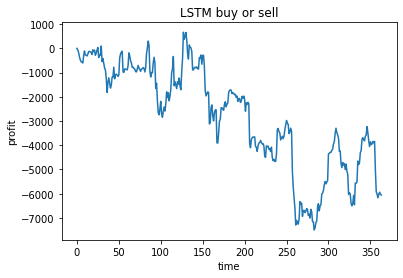

In [91]:
#シミュレーションを行う
money=[0]
profit=0
have=0
data=0
for i in range(len(ans)):
  if have==0:
    #sell
    if check[i]==0:
      have=1
      data=i
      continue
    #buy
    if check[i]==1:
      have=2
      data=i
      continue
  #sellでエントリーしている場合
  if have==1:
    #もし次がsellだと予測した場合は保有
    if check[i]==0:
      continue
    #もし次がbuyだと予測した場合は決済を行う
    if check[i]==1:
      profit+=price[data]-price[i]
      money.append(profit)
      have=0
      continue
  #buyでエントリーしている場合
  if have==2:
    #もし次がbuyだと予測した場合は保有を行う
    if check[i]==1:
      continue
    #もし次がsellだと予測した場合は決済を行う
    if check[i]==0:
      profit+=price[i]-price[data]
      money.append(profit)
      have=0
      continue
plt.plot(money)
plt.title('LSTM buy or sell')
plt.xlabel('time')
plt.ylabel('profit')
plt.savefig('/content2.png')
plt.show()

# Lightgbm+optunaで学習を行う｡
**特徴量としては､LSTMと異なり何個か前の価格やテクニカル指標は影響を受けずに学習させる**

**lightgbm+optunaでsell,buyの予測を行う**


In [ ]:
!pip install optuna

In [93]:
import optuna.integration.lightgbm as lgb
from sklearn.model_selection import train_test_split

In [ ]:
price=np.array(df3['price'])
PRICE=[]
action=[]
#sell1 buy2
for i in range(len(price)-2):
  new=price[i+2]-price[i+1]
  PRICE.append(new)
  if 0<new:
    action.append(1)
  else:
    action.append(0)
print(PRICE)
df5=df2[1:-1].reset_index(drop=True)
df5.insert(0,'action',action)
print(df5['action'].value_counts())

In [95]:
#actionは次取るべき行動を指す｡price[0]からprice[1]に価格が下がっているからaction[0]では0:sellの行動をしたほうが正しいという正解ラベルを与える｡
df5.head(3)

,action,price,sma20,bb_up,bb_low,macd,macdsignal,macdhist,rsi9,rsi14
0,0,44654.39,45350.6455,46531.145587,44170.145413,-212.402074,-142.232396,-70.169679,25.696322,31.249201
1,1,44529.61,45298.9325,46584.388807,44013.476193,-242.260572,-162.238031,-80.022541,23.061477,29.271623
2,1,44637.84,45262.3665,46616.919708,43907.813292,-254.259446,-180.642314,-73.617132,30.059392,33.219226


In [ ]:
x=df5.iloc[:,1:].reset_index(drop=True)
y=df5.iloc[:,0:1].reset_index(drop=True)
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,shuffle=False)
lgb_train=lgb.Dataset(x_train,y_train)
lgb_test=lgb.Dataset(x_test,y_test,reference=lgb_train)
param={
    'task':'train',
    'boosting_type':'gbdt',
    'obective':'binary',
    'verbose':'-1',
    'metric':'binary_error',
    }
best=lgb.train(param,
                lgb_train,
                valid_sets=lgb_test,
                early_stopping_rounds=500)
print(best.params)
print(best.best_iteration)
print(best.best_score)

In [97]:
predict=best.predict(x_test,num_iteration=best.best_iteration)
test=y_test.values.tolist()
check=[]
#testデータで精度の確認
for i in range(len(predict)):
  if predict[i]>=0.5:
    check.append(1)
  else:
    check.append(0)
answer=[]
for i in range(len(y_test)):
  if test[i][0]==0:
    answer.append(0)
  else:
    answer.append(1)
game=[]
for i in range(len(answer)):
  if answer[i]==check[i]:
    game.append('win')
  else:
    game.append('lose')

price=np.array(df5['price'][-(len(y_test)):])

print('予測とテストデータの一致した数:'+str(game.count('win')))
print('予測とテストデータの外した数:'+str(game.count('lose')))
print('sellを予測した数:'+str(check.count(0))+' buyを予測した数:'+str(check.count(1)))
print('実際のsellの数:'+str(answer.count(0))+'実際のbuyの数:'+str(answer.count(1)))

予測とテストデータの一致した数:650
予測とテストデータの外した数:543
sellを予測した数:533 buyを予測した数:660
実際のsellの数:656実際のbuyの数:537


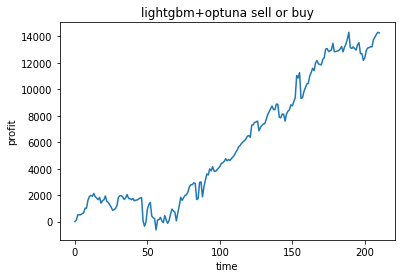

In [98]:
#シミュレーションを行う
money=[0]
profit=0
have=0
data=0
for i in range(len(ans)):
  if have==0:
    #sell
    if check[i]==0:
      have=1
      data=i
      continue
    #buy
    if check[i]==1:
      have=2
      data=i
      continue
  #sellでエントリーしている場合
  if have==1:
    #もし次がsellだと予測した場合は保有
    if check[i]==0:
      continue
    #もし次がbuyだと予測した場合は決済を行う
    if check[i]==1:
      profit+=price[data]-price[i]
      money.append(profit)
      have=0
      continue
  #buyでエントリーしている場合
  if have==2:
    #もし次がbuyだと予測した場合は保有を行う
    if check[i]==1:
      continue
    #もし次がsellだと予測した場合は決済を行う
    if check[i]==0:
      profit+=price[i]-price[data]
      money.append(profit)
      have=0
      continue
plt.plot(money)
plt.title('lightgbm+optuna sell or buy')
plt.xlabel('time')
plt.ylabel('profit')
plt.savefig('/content3.png')
plt.show()

**lightgbm+optunaでstay,sell,buyの予測を行う**

**stay or sell or buy**

In [99]:
price=np.array(df3['price'])
PRICE=[]
action=[]
#stay0 sell1 buy2
for i in range(len(price)-2):
  new=price[i+2]-price[i+1]
  PRICE.append(new)
  if -10.0<=new<=10.0:
    action.append(0)
    continue
  elif new<-10.0:
    action.append(1)
  elif 10.0<new:
    action.append(2)
df6=df2[1:-1].reset_index(drop=True)
df6.insert(0,'action',action)
print(df6['action'].value_counts())

1    2842
2    2753
0     369
Name: action, dtype: int64


In [100]:
df6.head(3)

,action,price,sma20,bb_up,bb_low,macd,macdsignal,macdhist,rsi9,rsi14
0,1,44654.39,45350.6455,46531.145587,44170.145413,-212.402074,-142.232396,-70.169679,25.696322,31.249201
1,2,44529.61,45298.9325,46584.388807,44013.476193,-242.260572,-162.238031,-80.022541,23.061477,29.271623
2,2,44637.84,45262.3665,46616.919708,43907.813292,-254.259446,-180.642314,-73.617132,30.059392,33.219226


In [ ]:
x=df6.iloc[:,1:].reset_index(drop=True)
y=df6.iloc[:,0:1].reset_index(drop=True)
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,shuffle=False)
lgb_train=lgb.Dataset(x_train,y_train)
lgb_test=lgb.Dataset(x_test,y_test,reference=lgb_train)

param={
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'multiclass',
    'num_class': 3,
    'verbose':'-1',
    'metric': 'multi_error', 
}
best=lgb.train(param,
              lgb_train,
              valid_sets=lgb_test,
              early_stopping_rounds=500)
print(best.params)
print(best.best_iteration)
print(best.best_score)


In [102]:
predict=best.predict(x_test,num_iteration=best.best_iteration)
test=y_test.values.tolist()
check=[]
#testデータで精度の確認
for i in range(len(x_test)):
  if predict[i][0]>predict[i][1]:
    if predict[i][0]>predict[i][2]:
      check.append(0)
    else:
      check.append(2)
  else:
    if predict[i][1]>predict[i][2]:
      check.append(1)
    else:
      check.append(2)
answer=[]
for i in range(len(y_test)):
  if test[i][0]==0:
    answer.append(0)
    continue
  elif test[i][0]==1:
    answer.append(1)
    continue
  elif test[i][0]==2:
    answer.append(2)
game=[]
for i in range(len(answer)):
  if answer[i]==check[i]:
    game.append('win')
  else:
    game.append('lose')
print('予測とテストデータの一致した数:'+str(game.count('win')))
print('予測とテストデータの外した数:'+str(game.count('lose')))
print('stayを予測した数:'+str(check.count(0))+' sellを予測した数:'+str(check.count(1))+' buyを予測した数:'+str(check.count(2)))
print('実際のstayの数:'+str(answer.count(0))+'実際のsellの数:'+str(answer.count(1))+'実際のbuyの数:'+str(answer.count(2)))

予測とテストデータの一致した数:606
予測とテストデータの外した数:587
stayを予測した数:0 sellを予測した数:525 buyを予測した数:668
実際のstayの数:76実際のsellの数:614実際のbuyの数:503


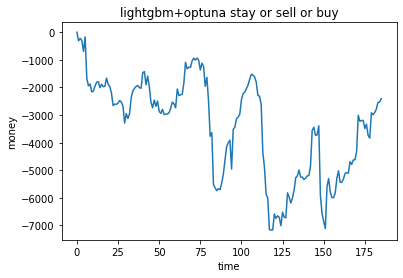

In [103]:
#シミュレーションを行う
money=[0]
profit=0
#haveはエントリーしていない、エントリーしている（sellは1,buyは2)を指す。
have=0
data=0
for i in range(len(ans)):
  #もっていない状態
  if have==0:
    #どういう行動を起こすか
    #stayなのでエントリーは行わない。
    if check[i]==0:
      continue
    #buyなのでbuyでエントリー
    if check[i]==2:
      have=2
      data=i
      continue
    #sellなのでsellでエントリー
    if check[i]==1:
      have=1
      data=i
      continue
  #sellでエントリーしている場合
  if have==1:
    #もし次がstayかsellだと予測した場合は保有
    if (check[i]==0 or check[i]==1):
      continue
    #もし次がbuyだと予測した場合は決済を行う
    if check[i]==2:
      profit+=price[data]-price[i]
      money.append(profit)
      have=0
      continue
  #buyでエントリーしている場合
  if have==2:
    #もし次がstayかbuyだと予測した場合は保有を行う
    if (check[i]==0 or check[i]==2):
      continue
    #もし次がsellだと予測した場合は決済を行う
    if check[i]==1:
      profit+=price[i]-price[data]
      money.append(profit)
      have=0
      continue

plt.plot(money)
plt.title('lightgbm+optuna stay or sell or buy')
plt.xlabel('time')
plt.ylabel('money')
plt.savefig('/content4.png')
plt.show()

#Lightgbm+optunaで学習させる

**特徴量としてLSTMと同様に何個か前の価格やテクニカル指標も影響を受けて学習をさせる**

**正解ラベルは0:sell,1:buy**

In [104]:
df5

,action,price,sma20,bb_up,bb_low,macd,macdsignal,macdhist,rsi9,rsi14
0,0,44654.39,45350.6455,46531.145587,44170.145413,-212.402074,-142.232396,-70.169679,25.696322,31.249201
1,1,44529.61,45298.9325,46584.388807,44013.476193,-242.260572,-162.238031,-80.022541,23.061477,29.271623
2,1,44637.84,45262.3665,46616.919708,43907.813292,-254.259446,-180.642314,-73.617132,30.059392,33.219226
3,1,44648.80,45215.3260,46606.770612,43823.881388,-259.888427,-196.491537,-63.396890,30.776678,33.623247
4,0,44659.13,45167.9625,46577.329451,43758.595549,-260.512861,-209.295801,-51.217059,31.521343,34.028367
...,...,...,...,...,...,...,...,...,...,...
5959,1,54306.74,54636.7390,56120.274641,53153.203359,-714.090296,-798.952412,84.862117,40.295850,35.019477
5960,1,54388.82,54577.5875,55920.551371,53234.623629,-664.554571,-772.072844,107.518273,42.765580,36.770630
5961,1,54591.47,54548.6435,55828.480821,53268.806179,-602.005447,-738.059365,136.053918,48.663916,40.998286
5962,1,54671.26,54513.3995,55664.673693,53362.125307,-539.774247,-698.402341,158.628094,50.905028,42.624923


In [105]:
def create_colums(new_df,old_df,num):
  new_df=old_df
  col=['price', 'sma20', 'bb_up', 'bb_low', 'macd', 'macdsignal','macdhist', 'rsi9', 'rsi14']
  for i in col:
    for j in range(1,int(num)):
      new_df[i+'_'+str(j)]=old_df[i].shift(j)
  new_df=new_df[num:].reset_index(drop=True)
  return new_df

In [106]:
df7=df5

In [107]:
df7=create_colums(df7,df5,5)

In [108]:
df7.head(3)

,action,price,sma20,bb_up,bb_low,macd,macdsignal,macdhist,rsi9,rsi14,price_1,price_2,price_3,price_4,sma20_1,sma20_2,sma20_3,sma20_4,bb_up_1,bb_up_2,bb_up_3,bb_up_4,bb_low_1,bb_low_2,bb_low_3,bb_low_4,macd_1,macd_2,macd_3,macd_4,macdsignal_1,macdsignal_2,macdsignal_3,macdsignal_4,macdhist_1,macdhist_2,macdhist_3,macdhist_4,rsi9_1,rsi9_2,rsi9_3,rsi9_4,rsi14_1,rsi14_2,rsi14_3,rsi14_4
0,1,44522.05,45091.601,46422.785654,43760.416346,-268.968438,-221.230329,-47.738109,27.159618,31.298453,44659.13,44648.80,44637.84,44529.61,45167.9625,45215.3260,45262.3665,45298.9325,46577.329451,46606.770612,46616.919708,46584.388807,43758.595549,43823.881388,43907.813292,44013.476193,-260.512861,-259.888427,-254.259446,-242.260572,-209.295801,-196.491537,-180.642314,-162.238031,-51.217059,-63.396890,-73.617132,-80.022541,31.521343,30.776678,30.059392,23.061477,34.028367,33.623247,33.219226,29.271623
1,1,44639.12,45022.957,46223.193113,43822.720887,-263.189094,-229.622082,-33.567012,35.707142,36.019231,44522.05,44659.13,44648.80,44637.84,45091.6010,45167.9625,45215.3260,45262.3665,46422.785654,46577.329451,46606.770612,46616.919708,43760.416346,43758.595549,43823.881388,43907.813292,-268.968438,-260.512861,-259.888427,-254.259446,-221.230329,-209.295801,-196.491537,-180.642314,-47.738109,-51.217059,-63.396890,-73.617132,27.159618,31.521343,30.776678,30.059392,31.298453,34.028367,33.623247,33.219226
2,0,44754.09,44965.864,46015.057947,43916.670053,-246.490415,-232.995748,-13.494667,43.085842,40.353870,44639.12,44522.05,44659.13,44648.80,45022.9570,45091.6010,45167.9625,45215.3260,46223.193113,46422.785654,46577.329451,46606.770612,43822.720887,43760.416346,43758.595549,43823.881388,-263.189094,-268.968438,-260.512861,-259.888427,-229.622082,-221.230329,-209.295801,-196.491537,-33.567012,-47.738109,-51.217059,-63.396890,35.707142,27.159618,31.521343,30.776678,36.019231,31.298453,34.028367,33.623247


In [109]:
df7['action'].value_counts()

0    3043
1    2916
Name: action, dtype: int64

In [ ]:
x=df7.iloc[:,1:].reset_index(drop=True)
y=df7.iloc[:,0:1].reset_index(drop=True)
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,shuffle=False)
lgb_train=lgb.Dataset(x_train,y_train)
lgb_test=lgb.Dataset(x_test,y_test,reference=lgb_train)

param={
    'task':'train',
    'boosting_type':'gbdt',
    'obective':'binary',
    'verbose':'-1',
    'metric':'binary_error',
}
best=lgb.train(param,
              lgb_train,
              valid_sets=lgb_test,
              early_stopping_rounds=500)
print(best.params)
print(best.best_iteration)
print(best.best_score)

In [111]:
predict=best.predict(x_test,num_iteration=best.best_iteration)
test=y_test.values.tolist()
check=[]
#testデータで精度の確認
for i in range(len(predict)):
  if predict[i]>=0.5:
    check.append(1)
  else:
    check.append(0)
answer=[]
for i in range(len(y_test)):
  if test[i][0]==0:
    answer.append(0)
  else:
    answer.append(1)
game=[]
for i in range(len(answer)):
  if answer[i]==check[i]:
    game.append('win')
  else:
    game.append('lose')

price=np.array(df5['price'][-(len(y_test)):])


print('予測とテストデータの一致した数:'+str(game.count('win')))
print('予測とテストデータの外した数:'+str(game.count('lose')))
print('sellを予測した数:'+str(check.count(0))+' buyを予測した数:'+str(check.count(1)))
print('実際のsellの数:'+str(answer.count(0))+'実際のbuyの数:'+str(answer.count(1)))

予測とテストデータの一致した数:660
予測とテストデータの外した数:532
sellを予測した数:600 buyを予測した数:592
実際のsellの数:656実際のbuyの数:536


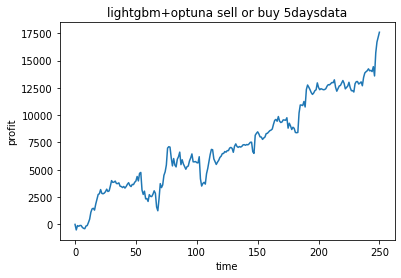

In [112]:
#シミュレーションを行う
money=[0]
profit=0
have=0
data=0
for i in range(len(ans)):
  if have==0:
    #sell
    if check[i]==0:
      have=1
      data=i
      continue
    #buy
    if check[i]==1:
      have=2
      data=i
      continue
  #sellでエントリーしている場合
  if have==1:
    #もし次がsellだと予測した場合は保有
    if check[i]==0:
      continue
    #もし次がbuyだと予測した場合は決済を行う
    if check[i]==1:
      profit+=price[data]-price[i]
      money.append(profit)
      have=0
      continue
  #buyでエントリーしている場合
  if have==2:
    #もし次がbuyだと予測した場合は保有を行う
    if check[i]==1:
      continue
    #もし次がsellだと予測した場合は決済を行う
    if check[i]==0:
      profit+=price[i]-price[data]
      money.append(profit)
      have=0
      continue
plt.plot(money)
plt.title('lightgbm+optuna sell or buy 5daysdata')
plt.xlabel('time')
plt.ylabel('profit')
plt.savefig('/content5.png')
plt.show()

**lightgbm+optuna 特徴量で5個前までのテクニカル指標たちも加える 正解ラベルは0:sell,1:sell 2:buy**

In [113]:
df8=df6

In [114]:
df8=create_colums(df8,df6,5)

In [115]:
df6.head(3)

,action,price,sma20,bb_up,bb_low,macd,macdsignal,macdhist,rsi9,rsi14,price_1,price_2,price_3,price_4,sma20_1,sma20_2,sma20_3,sma20_4,bb_up_1,bb_up_2,bb_up_3,bb_up_4,bb_low_1,bb_low_2,bb_low_3,bb_low_4,macd_1,macd_2,macd_3,macd_4,macdsignal_1,macdsignal_2,macdsignal_3,macdsignal_4,macdhist_1,macdhist_2,macdhist_3,macdhist_4,rsi9_1,rsi9_2,rsi9_3,rsi9_4,rsi14_1,rsi14_2,rsi14_3,rsi14_4
0,1,44654.39,45350.6455,46531.145587,44170.145413,-212.402074,-142.232396,-70.169679,25.696322,31.249201,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,44529.61,45298.9325,46584.388807,44013.476193,-242.260572,-162.238031,-80.022541,23.061477,29.271623,44654.39,NaN,NaN,NaN,45350.6455,NaN,NaN,NaN,46531.145587,NaN,NaN,NaN,44170.145413,NaN,NaN,NaN,-212.402074,NaN,NaN,NaN,-142.232396,NaN,NaN,NaN,-70.169679,NaN,NaN,NaN,25.696322,NaN,NaN,NaN,31.249201,NaN,NaN,NaN
2,2,44637.84,45262.3665,46616.919708,43907.813292,-254.259446,-180.642314,-73.617132,30.059392,33.219226,44529.61,44654.39,NaN,NaN,45298.9325,45350.6455,NaN,NaN,46584.388807,46531.145587,NaN,NaN,44013.476193,44170.145413,NaN,NaN,-242.260572,-212.402074,NaN,NaN,-162.238031,-142.232396,NaN,NaN,-80.022541,-70.169679,NaN,NaN,23.061477,25.696322,NaN,NaN,29.271623,31.249201,NaN,NaN


In [116]:
df8.head(3)

,action,price,sma20,bb_up,bb_low,macd,macdsignal,macdhist,rsi9,rsi14,price_1,price_2,price_3,price_4,sma20_1,sma20_2,sma20_3,sma20_4,bb_up_1,bb_up_2,bb_up_3,bb_up_4,bb_low_1,bb_low_2,bb_low_3,bb_low_4,macd_1,macd_2,macd_3,macd_4,macdsignal_1,macdsignal_2,macdsignal_3,macdsignal_4,macdhist_1,macdhist_2,macdhist_3,macdhist_4,rsi9_1,rsi9_2,rsi9_3,rsi9_4,rsi14_1,rsi14_2,rsi14_3,rsi14_4
0,2,44522.05,45091.601,46422.785654,43760.416346,-268.968438,-221.230329,-47.738109,27.159618,31.298453,44659.13,44648.80,44637.84,44529.61,45167.9625,45215.3260,45262.3665,45298.9325,46577.329451,46606.770612,46616.919708,46584.388807,43758.595549,43823.881388,43907.813292,44013.476193,-260.512861,-259.888427,-254.259446,-242.260572,-209.295801,-196.491537,-180.642314,-162.238031,-51.217059,-63.396890,-73.617132,-80.022541,31.521343,30.776678,30.059392,23.061477,34.028367,33.623247,33.219226,29.271623
1,2,44639.12,45022.957,46223.193113,43822.720887,-263.189094,-229.622082,-33.567012,35.707142,36.019231,44522.05,44659.13,44648.80,44637.84,45091.6010,45167.9625,45215.3260,45262.3665,46422.785654,46577.329451,46606.770612,46616.919708,43760.416346,43758.595549,43823.881388,43907.813292,-268.968438,-260.512861,-259.888427,-254.259446,-221.230329,-209.295801,-196.491537,-180.642314,-47.738109,-51.217059,-63.396890,-73.617132,27.159618,31.521343,30.776678,30.059392,31.298453,34.028367,33.623247,33.219226
2,0,44754.09,44965.864,46015.057947,43916.670053,-246.490415,-232.995748,-13.494667,43.085842,40.353870,44639.12,44522.05,44659.13,44648.80,45022.9570,45091.6010,45167.9625,45215.3260,46223.193113,46422.785654,46577.329451,46606.770612,43822.720887,43760.416346,43758.595549,43823.881388,-263.189094,-268.968438,-260.512861,-259.888427,-229.622082,-221.230329,-209.295801,-196.491537,-33.567012,-47.738109,-51.217059,-63.396890,35.707142,27.159618,31.521343,30.776678,36.019231,31.298453,34.028367,33.623247


In [117]:
df8['action'].value_counts()

1    2840
2    2750
0     369
Name: action, dtype: int64

In [ ]:
x=df8.iloc[:,1:].reset_index(drop=True)
y=df8.iloc[:,0:1].reset_index(drop=True)
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,shuffle=False)
lgb_train=lgb.Dataset(x_train,y_train)
lgb_test=lgb.Dataset(x_test,y_test,reference=lgb_train)
param={
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'multiclass',
    'num_class': 3,
    'metric': 'multi_error', 
}
best=lgb.train(param,
              lgb_train,
              valid_sets=lgb_test,
              early_stopping_rounds=500)
print(best.params)
print(best.best_iteration)
print(best.best_score)

In [120]:
predict=best.predict(x_test,num_iteration=best.best_iteration)
test=y_test.values.tolist()
check=[]
#testデータで精度の確認
for i in range(len(x_test)):
  if predict[i][0]>predict[i][1]:
    if predict[i][0]>predict[i][2]:
      check.append(0)
    else:
      check.append(2)
  else:
    if predict[i][1]>predict[i][2]:
      check.append(1)
    else:
      check.append(2)
answer=[]
for i in range(len(y_test)):
  if test[i][0]==0:
    answer.append(0)
    continue
  elif test[i][0]==1:
    answer.append(1)
    continue
  elif test[i][0]==2:
    answer.append(2)
game=[]
for i in range(len(answer)):
  if answer[i]==check[i]:
    game.append('win')
  else:
    game.append('lose')
print('予測とテストデータの一致した数:'+str(game.count('win')))
print('予測とテストデータの外した数:'+str(game.count('lose')))
print('stayを予測した数:'+str(check.count(0))+' sellを予測した数:'+str(check.count(1))+' buyを予測した数:'+str(check.count(2)))
print('実際のstayの数:'+str(answer.count(0))+'実際のsellの数:'+str(answer.count(1))+'実際のbuyの数:'+str(answer.count(2)))

予測とテストデータの一致した数:609
予測とテストデータの外した数:583
stayを予測した数:0 sellを予測した数:514 buyを予測した数:678
実際のstayの数:76実際のsellの数:614実際のbuyの数:502


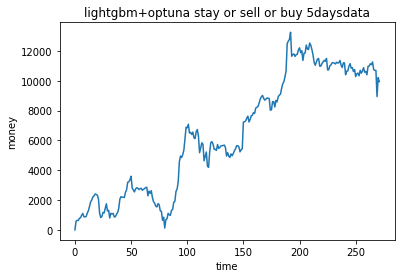

In [121]:
#シミュレーションを行う
money=[0]
profit=0
#haveはエントリーしていない、エントリーしている（sellは1,buyは2)を指す。
have=0
data=0
for i in range(len(ans)):
  #もっていない状態
  if have==0:
    #どういう行動を起こすか
    #stayなのでエントリーは行わない。
    if check[i]==0:
      continue
    #buyなのでbuyでエントリー
    if check[i]==2:
      have=2
      data=i
      continue
    #sellなのでsellでエントリー
    if check[i]==1:
      have=1
      data=i
      continue
  #sellでエントリーしている場合
  if have==1:
    #もし次がstayかsellだと予測した場合は保有
    if (check[i]==0 or check[i]==1):
      continue
    #もし次がbuyだと予測した場合は決済を行う
    if check[i]==2:
      profit+=price[data]-price[i]
      money.append(profit)
      have=0
      continue
  #buyでエントリーしている場合
  if have==2:
    #もし次がstayかbuyだと予測した場合は保有を行う
    if (check[i]==0 or check[i]==2):
      continue
    #もし次がsellだと予測した場合は決済を行う
    if check[i]==1:
      profit+=price[i]-price[data]
      money.append(profit)
      have=0
      continue

plt.plot(money)
plt.title('lightgbm+optuna stay or sell or buy 5daysdata')
plt.xlabel('time')
plt.ylabel('money')
plt.savefig('/content6.png')
plt.show()